### CS 178: Machine Learning &amp; Data Mining

# Discussion 03

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import requests                                        # for loading data from the web
from io import StringIO

from IPython import display

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import SGDClassifier         # Some scikit linear classifiers
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures   # feature transforms & pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

seed=1234
_=plt.set_cmap('jet')
np.random.seed(seed)

<Figure size 640x480 with 0 Axes>

# Linear Classifiers



This week we'll look at how linear classifiers work in some detail, as well as a bit on how to use them in the homework.

Let's start with some simple data for a classification example.  We'll use two features, $(x_1,x_2)$, and two classes, positive and negative (+1 vs. -1).

In [8]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=2)
y[y==0] = -1     # make {-1,1} instead of {0,1}

Xtr, Xte, ytr, yte = train_test_split(X, y)

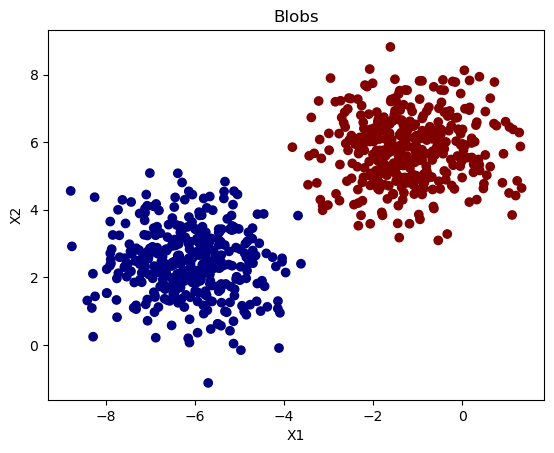

In [10]:
fig, ax = plt.subplots()

ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr);   # scatter plot, using "y" as the color
ax.set_title("Blobs");
ax.set_xlabel("X1");
ax.set_ylabel("X2");

Notice that this is a **classification** plot, in which our axes correspond to the **two features** $(x_1,x_2)$, and color is being used to indicate the target value $y$.

## Building a Classifier from the Ground Up

In the rest of the discussion we will show how to code a classifier from the ground up.

We will build a binary linear classifier, whose prediction rule is of the form,
$$ \hat y = f(x;\theta) = sign(\, \theta \odot x^T \,) $$
i.e., our prediction is class positive (+1) if $\theta \odot x^T > 0$, and class negative (-1) otherwise.

In [12]:
class Perceptron(object):
    def __init__(self):
        self.theta_ = None   # [theta0, slope1, slope2, ...]
    def predict(self,X):
        r = self.theta_[0] + self.theta_[1:] @ X.T   # we call "r" the "linear response"
        return np.sign(r)                            # then we threshold r to decide which class
    def fit(self, X,y):
        pass                # we'll fill this in later!

## Perceptron Algorithm
As a simple example we will use the [Perceptron Algorithm](https://en.wikipedia.org/wiki/Perceptron). We will build each part seperately, showing how it works.

We will use a 2 class perceptron with classes $\{-1, 1\}$. It is easy to alter to use classes $\{0,1\}$ instead (see below), and in lecture and on Wikipedia [page](https://en.wikipedia.org/wiki/Perceptron) you can see a generalization to more than two classes.

For an illustration of the algorithm you can watch this YouTube [clip](https://www.youtube.com/watch?v=vGwemZhPlsA)

### Decision Boundary of a Linear Classifier

The decision boundary is the set of points where our prediction "flips" from one class to another.  Let's visualize it directly (via brute force) first.

We start by initializing our model's parameters to something; let's say,
$$\theta_0 = -1 \qquad \theta_1 = 0.5 \qquad \theta_2 = 0.3$$

In [16]:
lc = Perceptron()
lc.theta_ = np.array([-1,0.5, 0.3])

If we just predict at every possible value $(x_1,x_2)$, we can see what the decision function looks like:

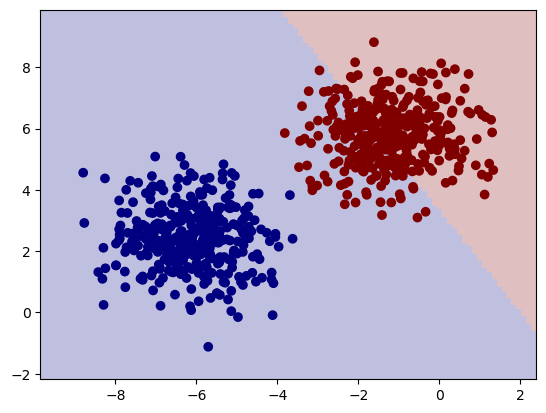

In [19]:
plot_kwargs = {'cmap':'jet',
               'response_method':'predict',
               'plot_method':'pcolormesh',
               'shading':'auto',
               'alpha':0.25,
               'grid_resolution':100 }

DecisionBoundaryDisplay.from_estimator(lc, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);

We can see that the decision boundary is a line -- where exactly is it located?

In this classifier, we can see that our prediction "flips" from positive to negative at exactly the points where $\theta \odot x^T = 0$.  More explicitly, for two features $x=(x_1,x_2)$, we have:
$$ \theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0$$

This is an $n-1$ dimensional linear space (since it is defined by a single linear equality); for $n=2$, then, it is a simple line.  

If we solve for $x_2$ (the vertical axis feature) in terms of $x_1$ (the horizontal axis), we get,
$$x_2 = -\frac{1}{\theta_2} \ \big(\theta_1 x_1 + \theta_0\big)$$

We can plot this on top to verify that it matches:

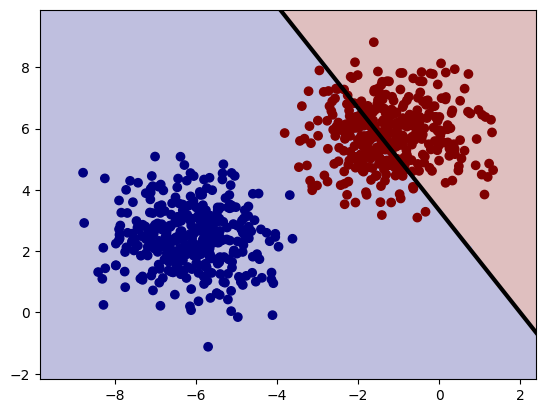

In [7]:
DecisionBoundaryDisplay.from_estimator(lc, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
ax = plt.axis()

x1s = np.linspace(-10,3,100)
x2s = -(lc.theta_[1]*x1s + lc.theta_[0])/lc.theta_[2]
plt.plot(x1s,x2s,'k-',lw=3)
plt.axis(ax);

Perfect!

## The Perceptron Algorithm

Now let's add a "fit" function to train our model, using the perceptron algorithm.  The perceptron algorithm just iterates through the data and performs a simple update (see slides):

In [23]:
def perceptron_algorithm( model, X, y, alpha=.005, epochs=100):
    m,n = X.shape

    # Initialize the model at random if we forgot to do it:
    if model.theta_ is None: model.theta_ = np.random.randn(n+1)

    err = (y != model.predict(X)).mean()
    for epoch in range(epochs):                          # 1 epoch = pass through all data
        for ii,i in enumerate(np.random.permutation(m)): # per epoch: permute data order
            yhati = model.predict(X[i:i+1,:])

            # "gradient-like" update rule:
            model.theta_[0] += alpha * (y[i]-yhati) * 1        # feature 0 is just 1
            model.theta_[1:]+= alpha * (y[i]-yhati) * X[i,:]   # other features

            if ii%20==0:                        # plot every 20 data points
                err = (y != model.predict(X)).mean()
                display.clear_output(wait=True)
                if X.shape[1]<=2: 
                    model.plot_boundary(X,y)
                    plt.gca().set_title(f'Error rate: {np.round(err,3)}')
                    plt.draw()
                    plt.pause(.01)
                else:                           # (if we can't plot...)
                    print('Suppressing plot (dim > 2)...')
                    print(f'Error rate: {np.round(err,3)}')

        if err==0.: break

In [25]:
# Re-define our class to include the training function and some visualizations:

class Perceptron(object):
    def __init__(self):
        self.theta_ = None   # [theta0, slope1, slope2, ...]
    def predict(self,X):
        r = self.theta_[0] + self.theta_[1:] @ X.T   # we call "r" the "linear response"
        return np.sign(r)                            # then we threshold r to decide which class

    def fit(self, X,y, *args,**kwargs):
        return perceptron_algorithm(self, X, y, *args,**kwargs)

    def plot_boundary(self,X,y):
        '''Quick & dirty 2D decision boundary line'''
        plt.gca().scatter(X[:,0],X[:,1], c=y);
        ax=plt.axis(); x1s=np.array([X[:,0].min(),X[:,0].max()])
        x2s = -(self.theta_[1]*x1s + self.theta_[0])/self.theta_[2]
        plt.gca().plot(x1s,x2s,'k-',lw=3); plt.axis(ax)

    def plot_decision(self,X,y):
        '''Fancier but slower decision boundary plot'''
        DecisionBoundaryDisplay.from_estimator(self, X, **plot_kwargs)
        plt.scatter(X[:,0],X[:,1], c=y);

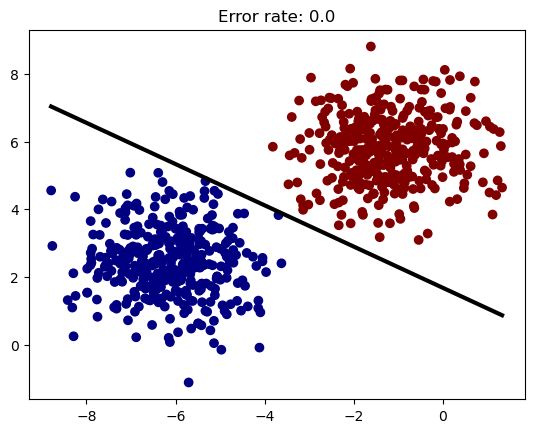

In [27]:
lc = Perceptron()

lc.theta_ = np.array([-1, 0.5, 0.3])   # can initialize manually or randomly

lc.fit(Xtr,ytr)

and, just to verify that our model's decisions are what we expect, we can use the fancier-looking, brute force decision function plot:

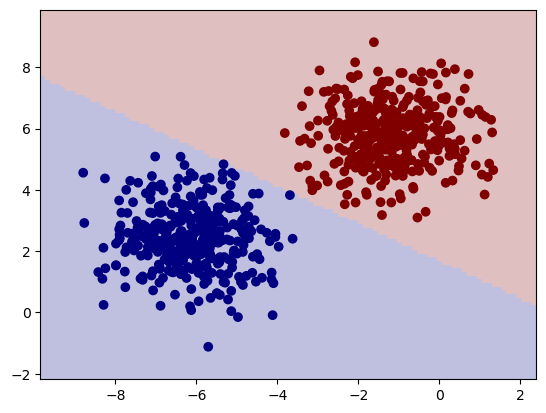

In [30]:
lc.plot_decision(Xtr,ytr)

### Feature Transforms

The easiest way to apply feature transforms, especially sequences of transforms, is via the ``sklearn`` ``Pipeline`` object.  This allows each component to be fit in sequence and saved, so that the sequence of operations can be re-applied later to test data.

Suppressing plot (dim > 2)...
Error rate: 0.0


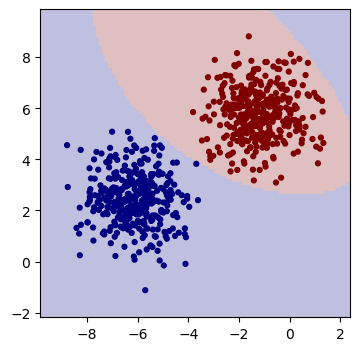

In [35]:

np.random.seed(111)

d = 3

# Each item in the pipeline is a pair, (name, transform); the end is (name, learner):
learner = Pipeline( [('poly',PolynomialFeatures(degree=d,include_bias=False)),
                     ('scale',StandardScaler()), 
                     ('percept',Perceptron())] )
                      
learner.fit(Xtr,ytr)

figure, axes = plt.subplots(1, 1, figsize=(4,4))
DecisionBoundaryDisplay.from_estimator(learner, Xtr, ax=axes, **plot_kwargs)
axes.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, edgecolor=None, s=12, cmap='jet');

We can access individual components of the pipeline via their names, e.g.,

In [38]:
learner['percept'].theta_

array([-0.88383833,  0.74988512,  1.76595455, -0.62939057, -0.38607545,
       -0.16086311,  0.18200179, -0.6272122 , -0.40671552, -0.86771018])

----

### Using ``scikit-learn`` for linear classifiers

``scikit-learn`` has a number of implementations of linear classifiers.  In the homework, you will be using ``SGDClassifier``, a generic linear classifier that can train using SGD on a variety of surrogate loss functions, including ``log_loss`` (corresponding to logistic regression) and ``hinge`` (corresponding to soft-margin support vector machines).

For example, we can initalize a ``SGDClassifier`` using the parameters we just learned for our linear classifier, and see that it produces the same decision boundary as the  ``Perceptron`` object ``lc`` that we made:

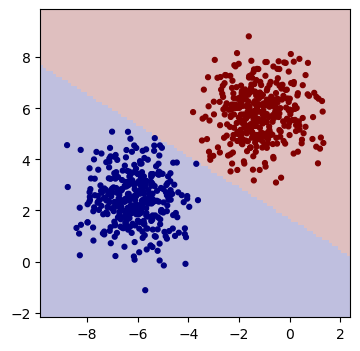

In [43]:
skmodel = SGDClassifier(loss='log_loss', warm_start=True, learning_rate='adaptive', eta0 = 1e-3)

# Now let's initialize the model manually:
skmodel.classes_ = np.unique(y)       # class IDs from the data (we'll assume # classes c=2)

skmodel.coef_ = lc.theta_[1:].reshape(1,-1)  # SGDClassifier keeps (c,n) coefficients, or (1,n) if c=2

skmodel.intercept_ = lc.theta_[0]            # c intercept terms, or scalar if c=2

figure, axes = plt.subplots(1, 1, figsize=(4,4))
DecisionBoundaryDisplay.from_estimator(skmodel, Xtr, ax=axes, **plot_kwargs)
axes.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, edgecolor=None, s=12, cmap='jet');

Now, we can perform a single epoch of SGD by calling ``partial_fit``. (The full ``fit`` function then runs multiple epochs and applies various stopping conditions).

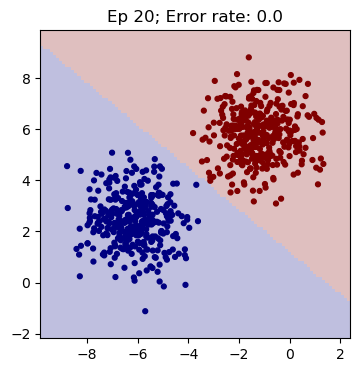

In [46]:
skmodel.coef_ = np.array([[0.5, 0.3]])   # should be (c,n)
skmodel.intercept_ = np.array([-1])      # should be (c,1)

skmodel.eta0 = 1e-4 ## very small so we can watch

for epoch in range(21):
    skmodel.partial_fit(Xtr,ytr)
    
    err = (y != skmodel.predict(X)).mean()
    display.clear_output(wait=True)
    figure, axes = plt.subplots(1, 1, figsize=(4,4))
    axes.set_title(f'Ep {epoch}; Error rate: {np.round(err,3)}')
    DecisionBoundaryDisplay.from_estimator(skmodel, Xtr, ax=axes, **plot_kwargs)
    axes.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, edgecolor=None, s=12, cmap='jet');
    plt.draw()
    plt.pause(1.01)

#figure, axes = plt.subplots(1, 1, figsize=(4,4))
#DecisionBoundaryDisplay.from_estimator(skmodel, Xtr, ax=axes, **plot_kwargs)
#axes.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, edgecolor=None, s=12, cmap='jet');